#INFO

**Moutning google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##imports

In [ ]:
import pandas as pd
import numpy as np


DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"

IMAGES = np.load(f'{DDSM_dir}/training/images.npy', allow_pickle=True)
MASKS = np.load(f'{DDSM_dir}/training/masks.npy', allow_pickle=True)

print(IMAGES.shape)
print(MASKS.shape)

(3568, 256, 256, 1)
(3568, 256, 256, 1)


In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

#utils

##**Metrics**

Mean IOU

In [ ]:
def iou_coef1(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
def iou_coef2(y_true, y_pred):
  smooth = K.epsilon() ##
  thr = 0.5 ###
  y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # apply threshold to prediction
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  return K.mean((intersection + smooth) / (union + smooth), axis=0)

Pescision and Recall

In [ ]:
def recall(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + smooth)
  return recall

def precision(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + smooth)
  return precision

F1 score

In [ ]:
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    # Ensure the F1 score is defined even when precision and recall are 0
    if p + r == 0:
        return 0.0

    f1 = 2 * ((p * r) / (p + r))
    return f1

In [ ]:
metrics = [iou_coef1,
           iou_coef2,
           #pixel_accuracy,
           recall,
           precision,
           f1]

##**Loss**

especially with class imbalance (which is common in biomedical imaging where the region of interest is often small compared to the entire image), the Dice loss alone may not be the best choice, as it can be biased towards the majority class. 
source : chatgpt

In [ ]:
def dice_coef(y_true, y_pred, smooth=.1):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection) / (K.sum(K.square(y_true)) + K.sum(K.square(y_pred)) + smooth)

In [ ]:
#dice coeff and iou coeff loss combind
def loss(y_true, y_pred):
  return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef1(y_true, y_pred))

##**Optimizers**

In [ ]:
def optimizer(lr):
  
  optimizer = optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
  )
  return optimizer

def lr_schedule(initial = 0.01):
  initial_learning_rate = 0.01
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                               decay_steps=100000, 
                                                               decay_rate=0.96, staircase=True
                                                                )
  return lr_schedule

##**callbacks**

In [ ]:
def build_callbacks(model_name, patience = 10): 
    callback= [ModelCheckpoint(f'/content/drive/MyDrive/trained_models/U-Net/{model_name}.h5',verbose =1, save_best_only=True),
    EarlyStopping(patience = patience, verbose =1, restore_best_weights=True ,monitor = "val_loss")]
    return callback

#Model architicture

In [ ]:
def down_block(input,start_neurons):
    conv = Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(input)
    conv = BatchNormalization()(conv)
    conv = Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    pool = Dropout(0.1)(pool)

    return conv , pool


def up_block(input,skip_features,start_neurons):
    up = concatenate([Conv2DTranspose(start_neurons, (2, 2), strides=(2, 2), padding='same')(input), skip_features], axis=3)
    conv = Dropout(0.1)(up)
    conv = Conv2D(start_neurons , (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Conv2D(start_neurons , (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)

    return conv


In [ ]:
def unet(input_size = (256,256,1) , start_neurons = 32):

    inputs = Input(input_size)

    #downblocks
    conv1 , pool1 = down_block(inputs, start_neurons * 1)
    conv2 , pool2 = down_block(pool1, start_neurons * 2)
    conv3 , pool3 = down_block(pool2, start_neurons * 4)
    conv4 , pool4 = down_block(pool3, start_neurons * 8) 
    conv5 , pool5 = down_block(pool4, start_neurons * 16)
    conv6 , pool6 = down_block(pool5, start_neurons * 32)

    #middle (we don't need pool in the middle)
    mconv, _ = down_block(pool6 , start_neurons * 64)

    #upblocks
    uconv6 = up_block(mconv, conv6 , start_neurons * 32)
    uconv5 = up_block(uconv6, conv5 , start_neurons * 16)
    uconv4 = up_block(uconv5 , conv4 , start_neurons * 8)
    uconv3 = up_block(uconv4, conv3 , start_neurons * 4)
    uconv2 = up_block(uconv3 , conv2 , start_neurons * 2)
    uconv1 = up_block(uconv2 , conv1 , start_neurons * 1)

    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(uconv1)

    model = Model(inputs=[inputs], outputs=[output_layer])
    return model

In [ ]:
def unet1(input_size = (256,256,1), start_neurons=64):
    input_layer = Input(input_size)
    conv1 = Conv2D(start_neurons * 1, 3, activation="relu", padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(start_neurons * 1, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, 3, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, 3, activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, 3, activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, 3, activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, 3, activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, 3, strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, 3, activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, 3, activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, 3, strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, 3, activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, 3, activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, 3, strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, 3, activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, 3, activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, 3, strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, 3, activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, 3, activation="relu", padding="same")(uconv1)

    covout = Conv2D(2,1,activation="relu", padding="same")(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(covout)

    model = Model(inputs = [input_layer], outputs = [output_layer])
    
    return model

In [ ]:
model = unet()

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_161 (Conv2D)            (None, 256, 256, 32  320         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_99 (BatchN  (None, 256, 256, 32  128        ['conv2d_161[0][0]']             
 ormalization)                  )                                                           

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 53.2 MB/s eta 0:00:00


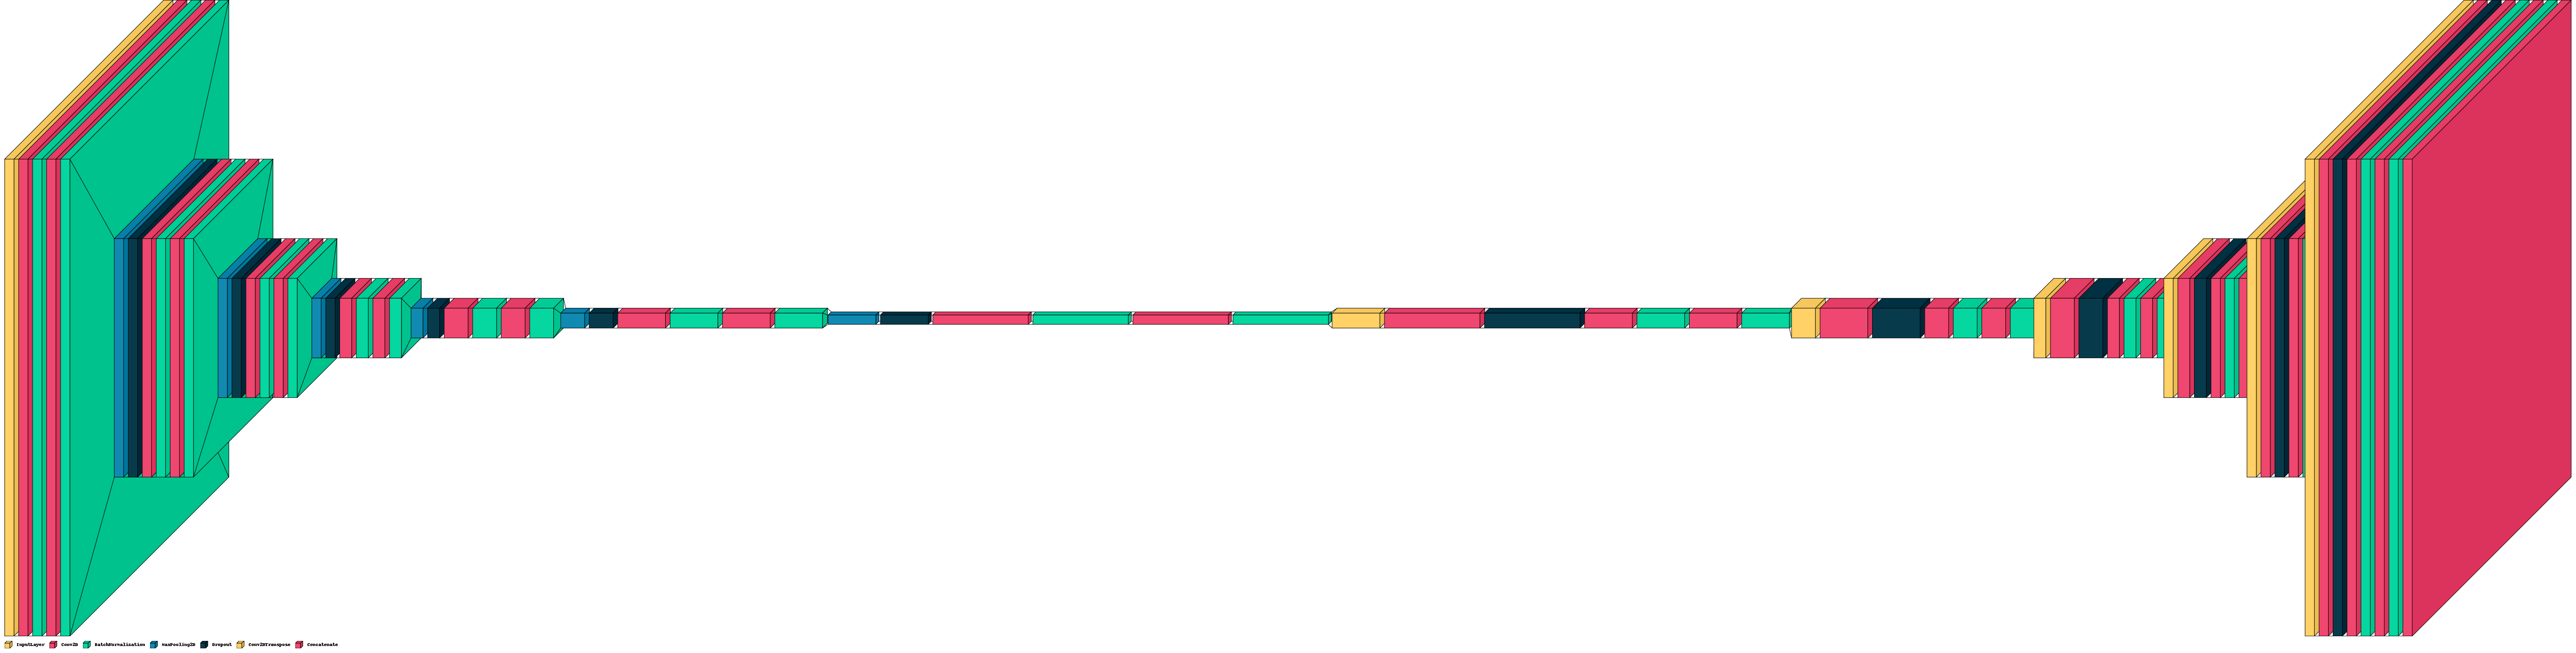

In [ ]:
import visualkeras
visualkeras.layered_view(model,legend=True, draw_volume=True)

#**Fitting**

for the trining we will we can change different

 - optimizers
 - losses
 - we can also change the number of nnuerons in our model

##functions

defining a function to train the model of which some parameters we can change

In [ ]:
x_train = None 
x_test = None
y_train = None
y_test = None
x_val = None
y_val = None

In [ ]:
def train(name,opt, loss, d_divisor = 1, batch_size = 1 , epochs = 100 , sart_neurons = 32 , verbose = 0, patience = 35):
  # optimizor
  # loss
  # data divisor is used to make the data smaller d_divisor = 1 mean it's the largest data
  global x_train, x_test, y_train, y_test, x_val, y_val

  #spliting the data
  IMAGES_sub = np.split(IMAGES, d_divisor)[0] 
  MASKS_sub = np.split(MASKS, d_divisor)[0] 

  # Split dataset into train and test sets (80/20 split)
  x_train, x_test, y_train, y_test = train_test_split(IMAGES_sub, MASKS_sub, test_size=0.2, random_state=42)

  # Split training set into train and validation sets (80/20 split)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

  # the model needs the mask to be floating point
  y_train = y_train.astype('float32')
  y_val = y_val.astype('float32')

  #model compilation
  model = unet(start_neurons = sart_neurons)
  model.compile(opt, loss=loss, metrics=metrics)

  train_steps = x_train.shape[0] // batch_size
  test_steps = x_val.shape[0] // batch_size


  print("\n Model is training") 

  history = model.fit(x=x_train, 
                      y=y_train, 
                      epochs=epochs,
                      steps_per_epoch = train_steps, 
                      validation_steps= test_steps ,
                      callbacks = build_callbacks(name,patience),
                      batch_size = batch_size, 
                      validation_data=(x_val, y_val),
                      shuffle=False,
                      verbose = verbose)
  
  print("\n Model history")
  
  plot_history(history)

  print("\n ====================================================")
  print("\n predicting on a test set") 

  pred = model.predict(x_test)

  print("\n plotting a sample of the predicted output")
  plot_prediction(pred)

  return model , history

**Function to plot the history**

In [ ]:
def plot_history(history):
    metrics = [key for key in history.history.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    num_cols = 3
    num_rows = math.ceil(num_metrics / num_cols)

    plt.figure(figsize=(12, 4 * num_rows))
    
    for i, metric in enumerate(metrics):
        plt.subplot(num_rows, num_cols, i+1)
        
        plt.plot(history.history[metric])
        if 'val_'+metric in history.history.keys():
            plt.plot(history.history['val_'+metric])
        
        plt.title('Model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

function to plot a random sample

In [ ]:
def plot_image(img):
  plt.imshow(img.reshape(256,256), interpolation='nearest')
  plt.show()
  return plt

def plot_prediction(y_pred, num_samples=5):
    # Choose random indices
    indices = np.random.choice(np.arange(y_pred.shape[0]), size=num_samples, replace=False)
    
    for idx in indices:
        # Get data
        x = x_test[idx]
        true = y_test[idx] # true mask
        pred = y_pred[idx]
        binary_pred = np.where(pred > 0.5, 1, 0) #pred after post proccessing


        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot original image
        axs[0].imshow(x, cmap='gray')
        axs[0].set_title("Original Image")

        # Plot prediction
        axs[1].imshow(pred.squeeze(), cmap='gray')
        axs[1].set_title("Predicted")

        # Plot binary prediction
        axs[2].imshow(binary_pred.squeeze(), cmap='gray')
        axs[2].set_title("Binary Predicted")


        # Plot ground truth
        axs[3].imshow(true.squeeze(), cmap='gray')
        axs[3].set_title("Ground Truth")


        # Hide the axes
        for ax in axs:
            ax.axis('off')

        plt.show()

##Training


 Model is training
Epoch 1/100
2283/2283 [==============================] - ETA: 0s - loss: -0.0716 - iou_coef1: 0.0454 - iou_coef2: 0.9279 - recall: 0.3520 - precision: 0.0812 - f1: 0.0926
Epoch 1: val_loss improved from inf to -0.05295, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_6_diceloss.h5
2283/2283 [==============================] - 418s 174ms/step - loss: -0.0716 - iou_coef1: 0.0454 - iou_coef2: 0.9279 - recall: 0.3520 - precision: 0.0812 - f1: 0.0926 - val_loss: -0.0530 - val_iou_coef1: 0.0344 - val_iou_coef2: 0.9682 - val_recall: 0.1199 - val_precision: 0.0857 - val_f1: 0.0569
Epoch 2/100
2283/2283 [==============================] - ETA: 0s - loss: -0.1183 - iou_coef1: 0.0899 - iou_coef2: 0.9771 - recall: 0.2601 - precision: 0.1416 - f1: 0.1444
Epoch 2: val_loss improved from -0.05295 to -0.07272, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_6_diceloss.h5
2283/2283 [==============================] - 407s 178ms/step - loss: -0.1183 - i

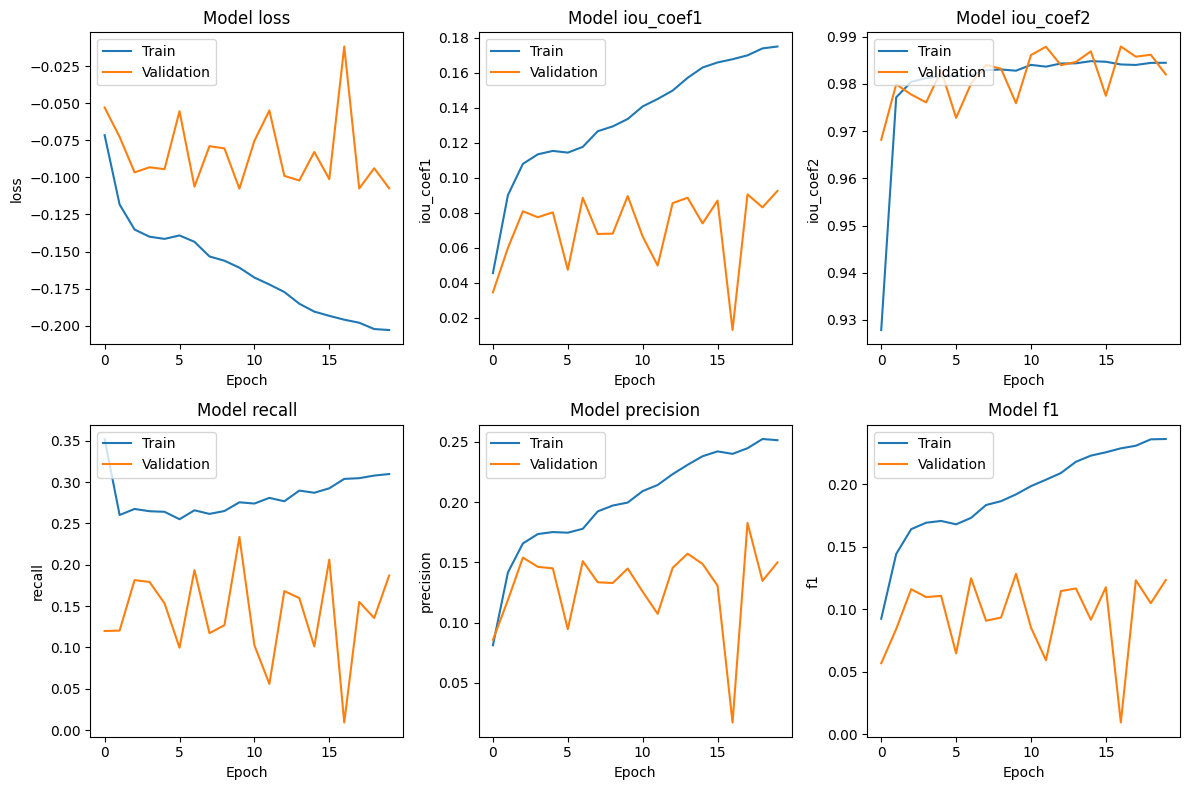



 predicting on a test set
23/23 [==============================] - 6s 236ms/step

 plotting a sample of the predicted output


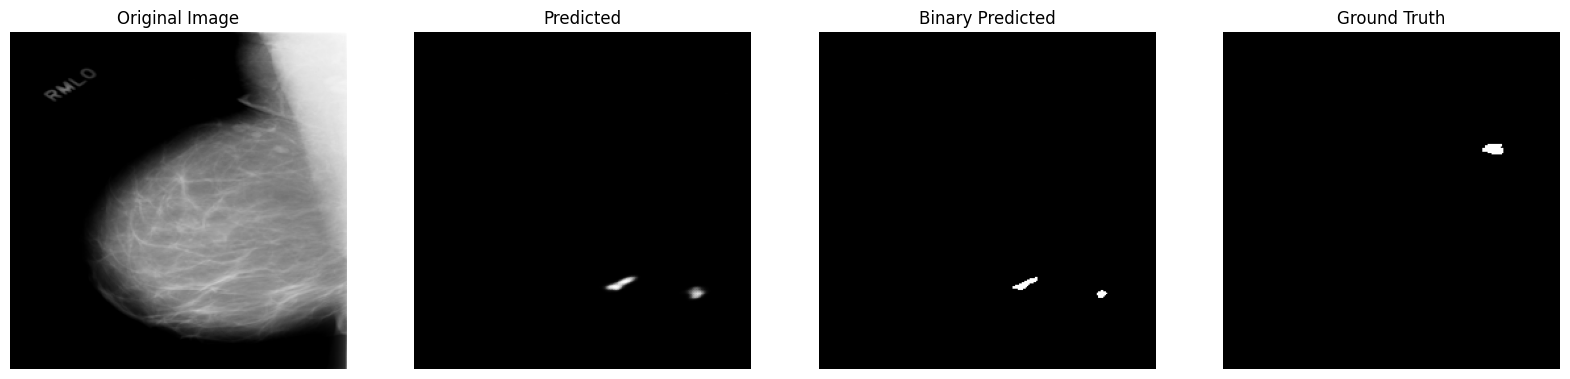

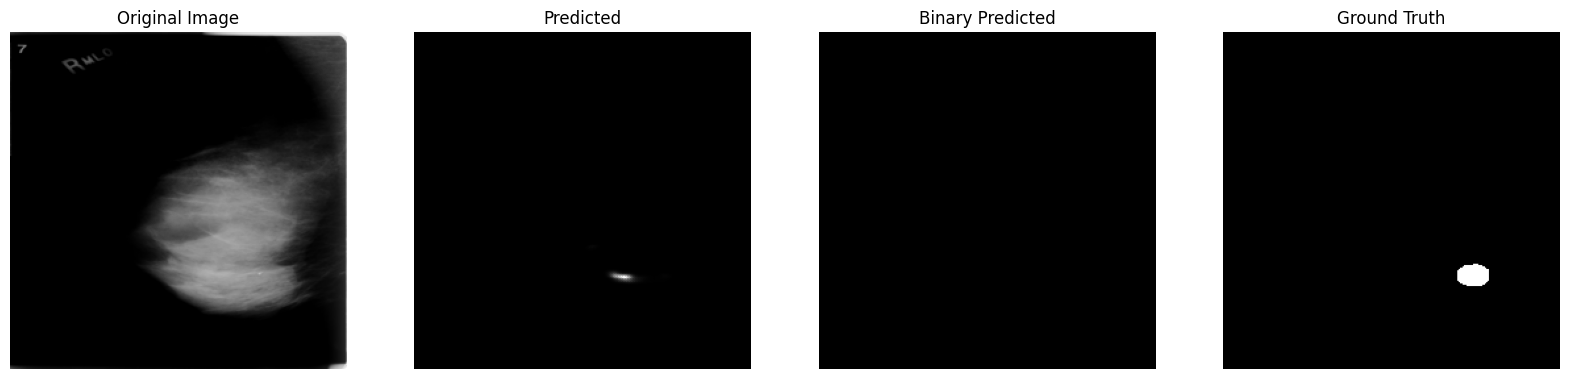

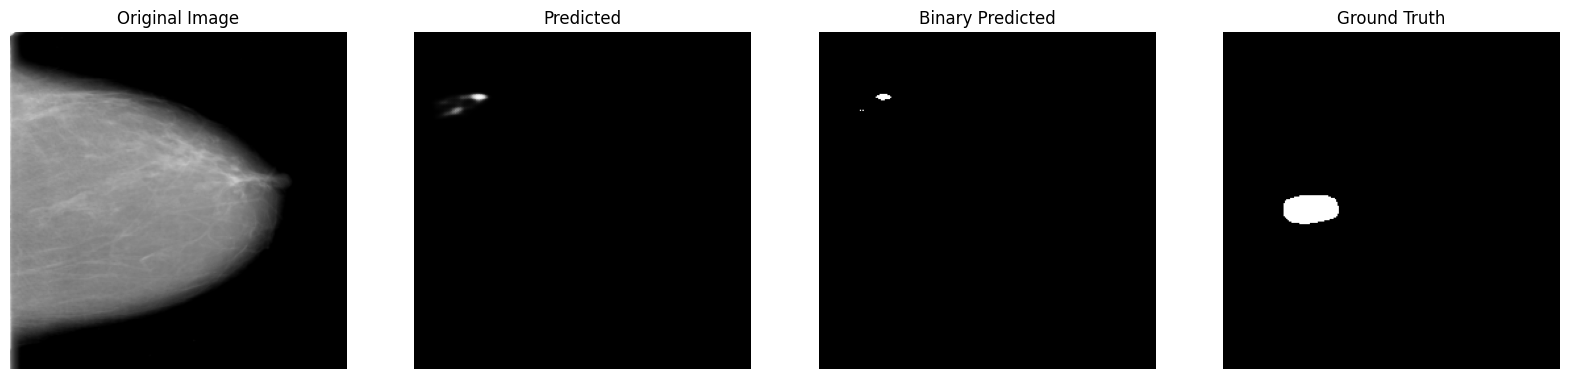

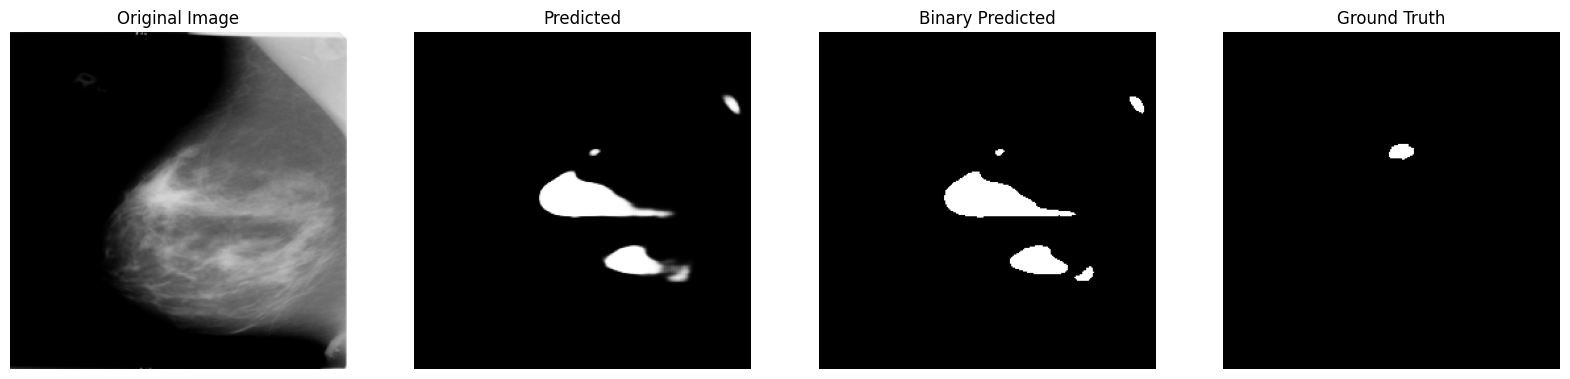

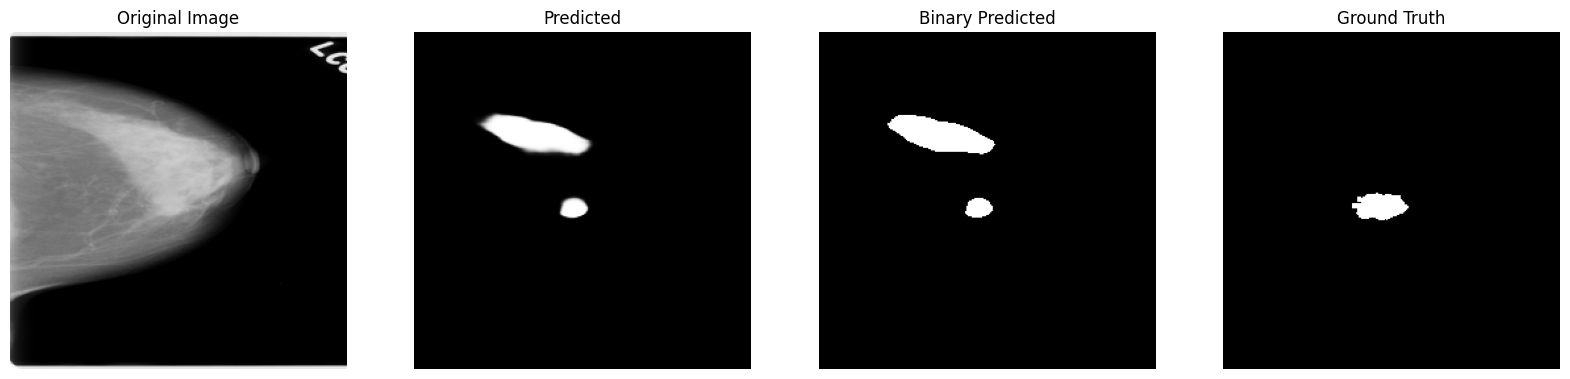

In [68]:
model, hist = train("unet_6_diceloss",
                    optimizer(0.001),
                    loss,
                    batch_size = 1,
                    epochs = 100,
                    verbose = 1,
                    patience = 10)

23/23 [==============================] - 5s 218ms/step


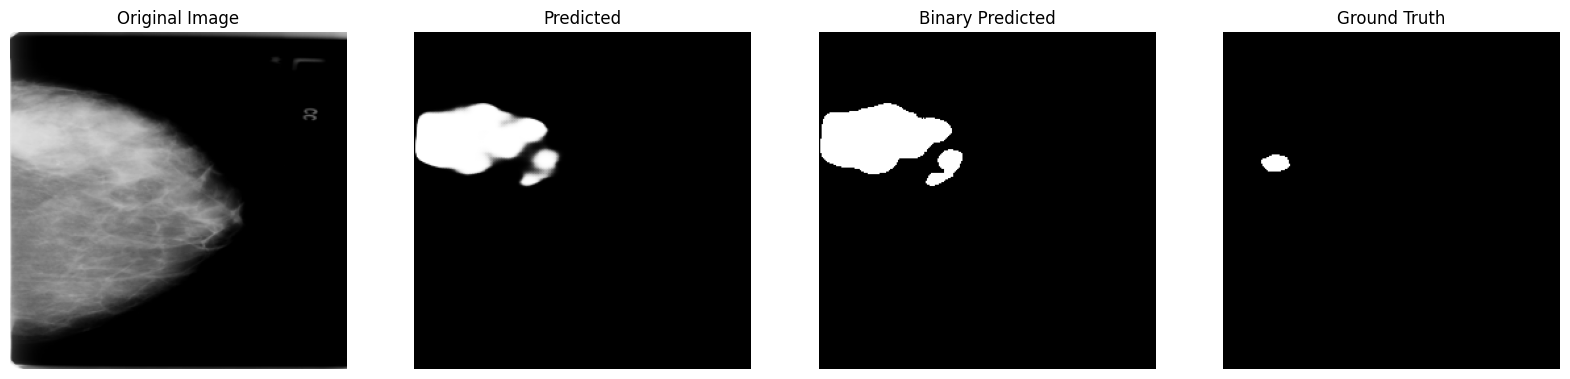

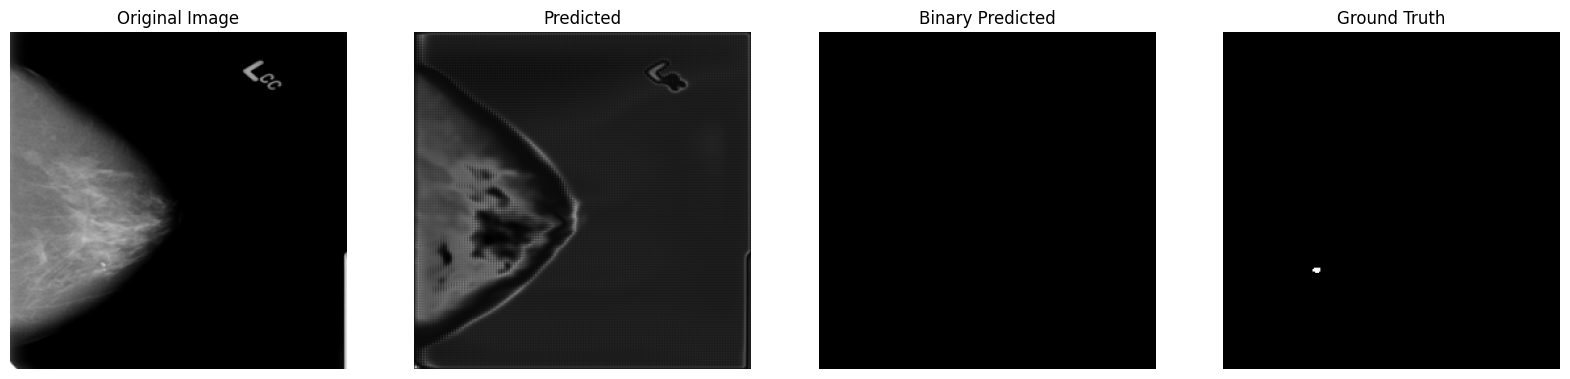

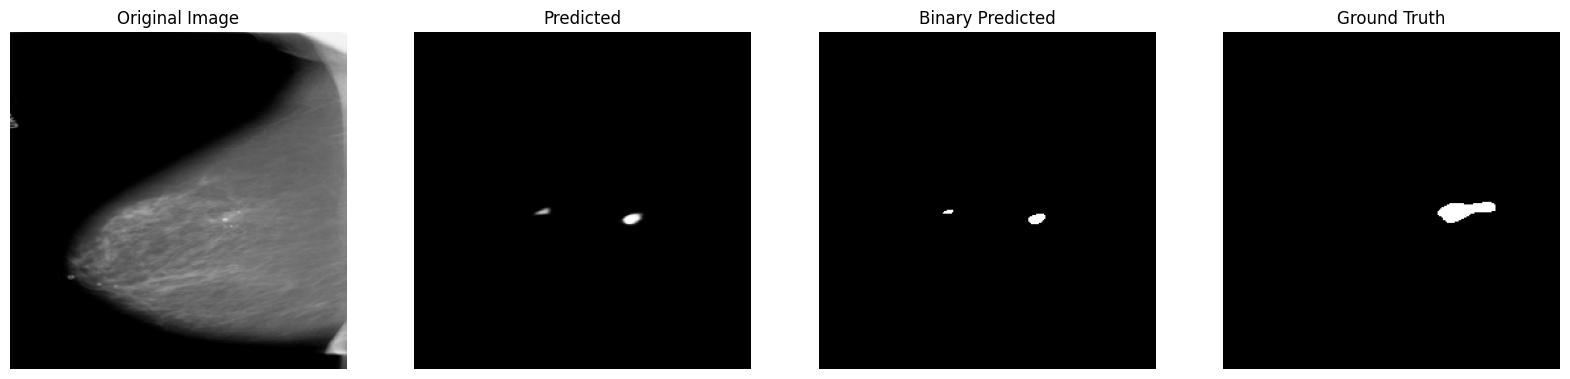

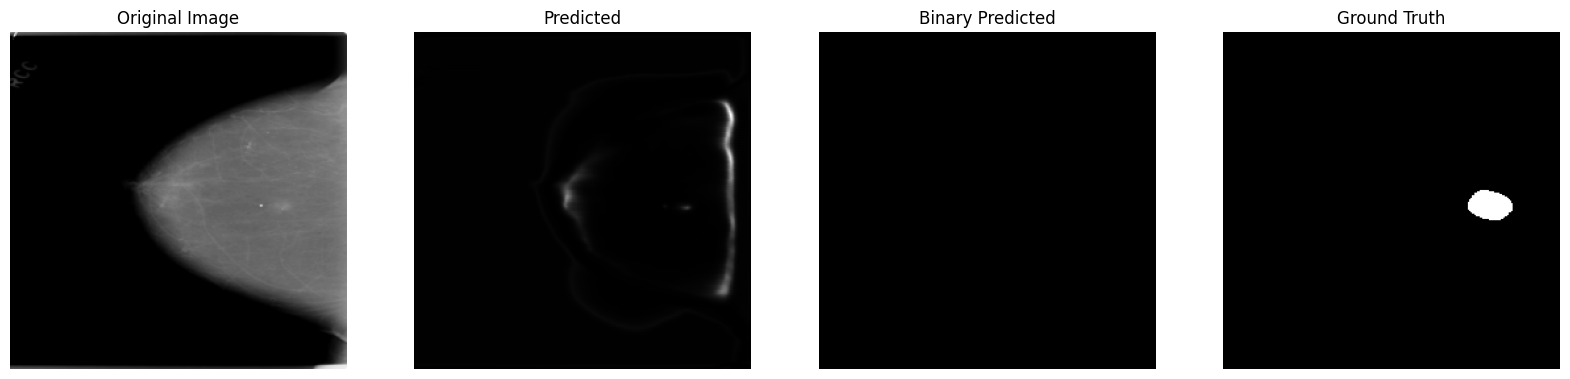

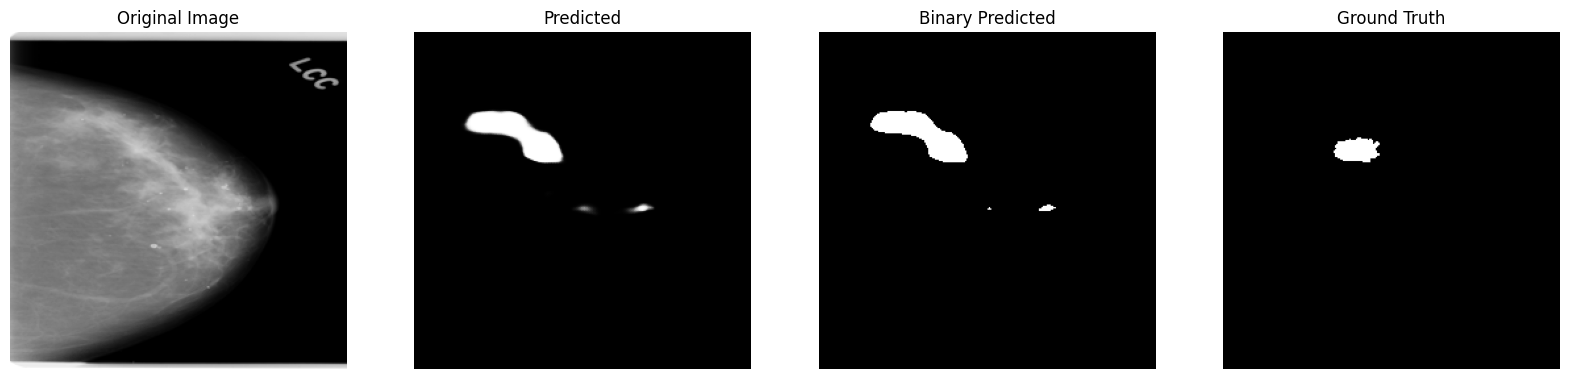

In [70]:
pred = model.predict(x_test)
plot_prediction(pred)